In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics.pairwise import cosine_similarity

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
def prepare_data():
    data = np.load('/content/gdrive/My Drive/data/stereo_matching/cosine_1.npy')
    
    data = data.transpose((0, 4, 2, 3, 1))
    data = data.reshape(data.shape[0], 15, 15, 2)
    
    # normalization
    mean = np.mean(data)
    std  = np.std(data)
    data = (data - mean)/(std+1e-7)
    
    return data

In [3]:
# get data
data = prepare_data()
print(data.shape)

# get labels
Y = np.load('/content/gdrive/My Drive/data/stereo_matching/labels_consine.npy')
print(Y.shape)

(1000000, 15, 15, 2)
(1000000,)


In [4]:
# shuffle
data_size = data.shape[0]

rng = np.random.RandomState(113)
indices = np.arange(data_size)

rng.shuffle(indices)
data = data[indices]
Y = Y[indices]

In [5]:
# prepare training and validation sets
split = 0.8
split = int(data_size*split)

trainX = data[:split]
testX  = data[split:]

trainY = Y[:split]
testY  = Y[split:]

In [6]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(800000, 15, 15, 2)
(200000, 15, 15, 2)
(800000,)
(200000,)


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization
import tensorflow as tf

def base_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (1,1),activation='relu', kernel_initializer='he_uniform')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, (1,1), activation='tanh')(x)
    x = tf.squeeze(x)
    model = Model(inputs=inputs, outputs=x)
    return model

In [8]:
model = base_model((15, 15, 2))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 15, 2)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 15, 15, 32)        96        
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 11, 32)        128   

In [9]:
X = tf.random.normal((128, 15, 15, 2))
Y = tf.random.normal((128,))

print(X.shape)
print(Y.shape)

(128, 15, 15, 2)
(128,)


In [10]:
# predict
pred = model(X)

# loss
print(pred.shape)
print(Y.shape)

(128,)
(128,)


In [11]:
# training
batch_size = 512
epochs = 30

opt_adam = keras.optimizers.Adam()
model.compile(loss='mse', optimizer=opt_adam)
history = model.fit(trainX, trainY, batch_size = batch_size, validation_split=0.2, epochs=epochs)

Epoch 1/30
1250/1250 [==============================] - 45s 34ms/step - loss: 0.0508 - val_loss: 0.0075
Epoch 2/30
1250/1250 [==============================] - 42s 33ms/step - loss: 0.0085 - val_loss: 0.0053
Epoch 3/30
1250/1250 [==============================] - 42s 34ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 4/30
1250/1250 [==============================] - 42s 33ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 5/30
1250/1250 [==============================] - 42s 34ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 6/30
1250/1250 [==============================] - 42s 34ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 7/30
1250/1250 [==============================] - 42s 34ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 8/30
1250/1250 [==============================] - 42s 34ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 9/30
1250/1250 [==============================] - 42s 34ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 10/30
1250/1250 [==============================] - 42s 34m

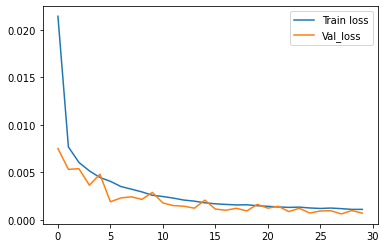

In [12]:
# Plot the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label = 'Val_loss')
plt.legend()

In [13]:
#Save model to cosin.h5 file
model.save('/content/gdrive/My Drive/data/stereo_matching/model_cosine_fit_v1.h5')